### Odwiedzi  nas czy wystawi? 
 
> **1. Dane:**


_Nasze dane opisują informacje dotyczące rezerwacji w hotelach w Portugalii takie jak:_


* daty rezerwacji, 
* długosc pobytu, 
* ilość gości wraz z ilościa dzieci oraz niemowląt,
* rezerwacje w podziale na segment rynku,
* liczba zarezerwowanych miejsc parkingowych
oraz wiele innych.


_Dane personalne nie występują w tym zbiorze danych i obejmują okolo 120 tysięcy rekordów.
Dane zostały pobrane z [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand)_


> **2. Cel prezentacji:**


* Prognozowanie czy rezerwacja zostanie wykorzystana  czy anulowana 
* Aplikacja do szacowania obłożenia hotelu
* Propozycja dla biznesu: jakie korzyści da wdrożenie wybranego przez nas modelu.

### Analiza danych

In [45]:

import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, RocCurveDisplay, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, make_scorer, fbeta_score,accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from time import time
from sklearn.linear_model import RidgeCV
import scikitplot as skplt
import plotly.express as px
import folium
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
# import eli5 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD
import warnings

random_state=42

In [46]:

data_df = pd.read_csv("hotel_bookings.csv")
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 200000
data_df = data_df.drop(columns=["reservation_status_date", "hotel", "reservation_status",
    "arrival_date_week_number", "reserved_room_type", "company"])

data_df["total_guests"] = data_df["adults"] + data_df["children"] + data_df["babies"]
data_df["price_per_guest"] = data_df["adr"]/data_df["total_guests"]

filter = (data_df.children == 0) & (data_df.adults == 0) & (data_df.babies == 0)
data_df[filter]
data_df = data_df[~filter]
data_df=data_df.replace(" ","_")
data_df = data_df.reindex(data_df.columns.tolist(), axis = 1)

In [47]:

nan_replacements = {"children": 0.0, "agent": 0, "country": "unknown", "total_guests":0, "price_per_guest":0}
data_df = data_df.fillna(nan_replacements)
# data_df.info()

In [48]:

data_df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,total_guests,price_per_guest
count,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000,119210.00000
mean,0.37077,104.10923,2016.15647,15.79872,0.92705,2.49919,1.85921,0.10404,0.00796,0.03150,0.08719,0.13709,0.21880,74.88908,2.32121,101.96909,0.06255,0.57150,1.97113,54.98848
std,0.48301,106.87545,0.70749,8.78107,0.99512,1.89711,0.57519,0.39884,0.09751,0.17466,0.84492,1.49814,0.63850,107.16888,17.59800,50.43401,0.24536,0.79288,0.71896,29.05949
min,0.00000,0.00000,2015.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-6.38000,0.00000,0.00000,0.00000,-3.19000
25%,0.00000,18.00000,2016.00000,8.00000,0.00000,1.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,7.00000,0.00000,69.50000,0.00000,0.00000,2.00000,37.40000
50%,0.00000,69.00000,2016.00000,16.00000,1.00000,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,9.00000,0.00000,94.95000,0.00000,0.00000,2.00000,49.50000
75%,1.00000,161.00000,2017.00000,23.00000,2.00000,3.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,152.00000,0.00000,126.00000,0.00000,1.00000,2.00000,66.00000
max,1.00000,737.00000,2017.00000,31.00000,19.00000,50.00000,55.00000,10.00000,10.00000,1.00000,26.00000,72.00000,18.00000,535.00000,391.00000,5400.00000,8.00000,5.00000,55.00000,2700.00000


In [49]:

data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data_df.dropna(inplace=True)

data_df.drop(14969)
data_df.shape

(119210, 28)

In [50]:

# funkcja zwracająca cechy numeryczne
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

# funkcja rysująca histogramy dla numerycznych cechy
def draw_histograms(dataframe, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        dataframe[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

20


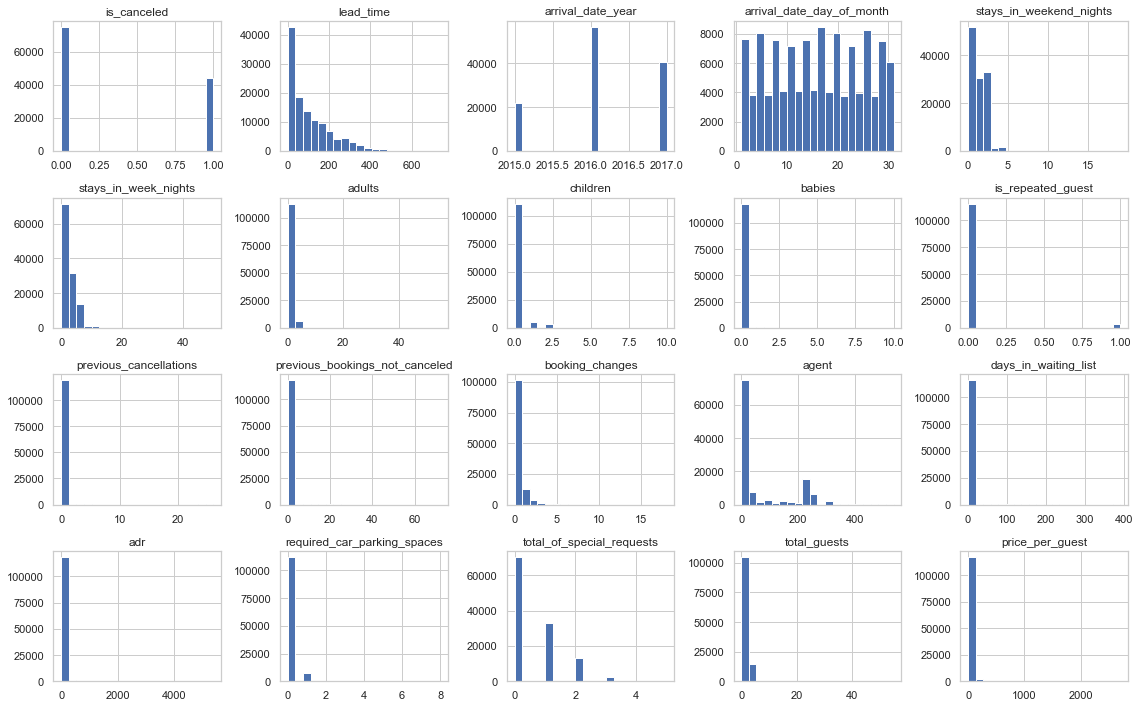

In [71]:

warnings.filterwarnings("ignore")

feats = get_quant_features(data_df)
print(len(feats))
draw_histograms(data_df, feats, 4, 5)

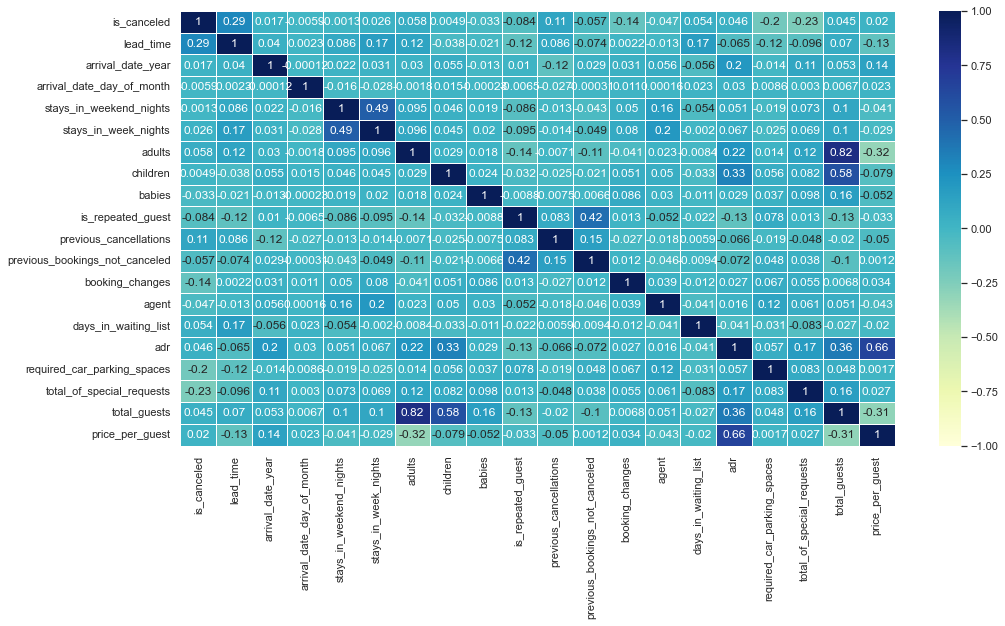

In [52]:

plt.rcParams["figure.figsize"]=(16,8)
sns.heatmap(data_df.corr(method="pearson",), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

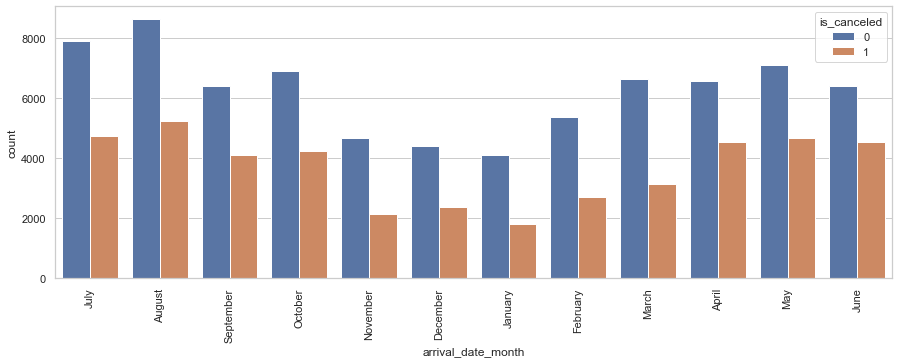

In [53]:

plt.figure(figsize=(15, 5))
sns.countplot(x="arrival_date_month", hue="is_canceled", data=data_df)
plt.xticks(rotation=90);

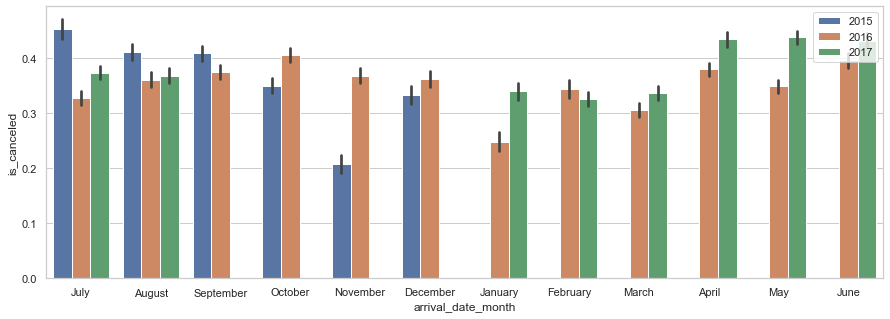

In [54]:

plt.figure(figsize=(15,5))
sns.barplot(x="arrival_date_month", y="is_canceled", hue="arrival_date_year", data=data_df)
plt.legend(loc="upper right");

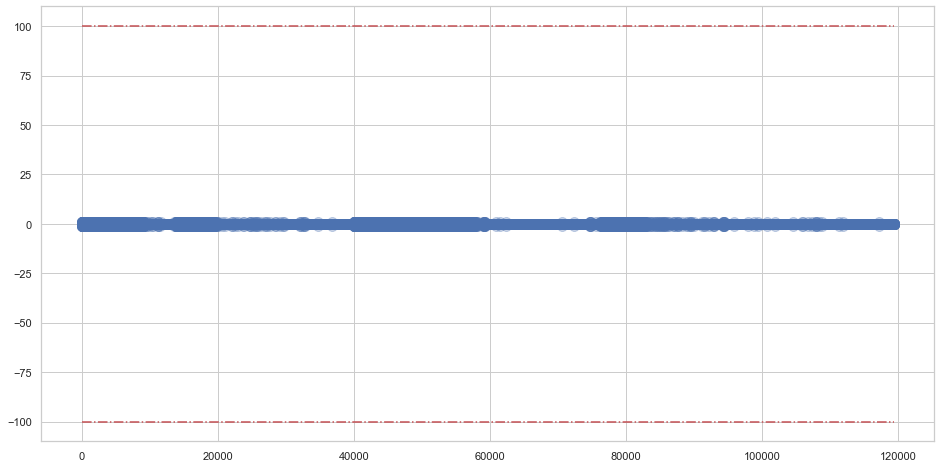

In [55]:

# sprawdzamy, czy są jakieś wartości odstające
# pd.diff() sprawdza różnice co do poprzedniego elementu
plt.plot(data_df.index, data_df["is_canceled"].diff(), "bo", alpha=0.3, ms=10, lw="3")

plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=100, color="r", linestyle="-.")
plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=-100, color="r", linestyle="-.");

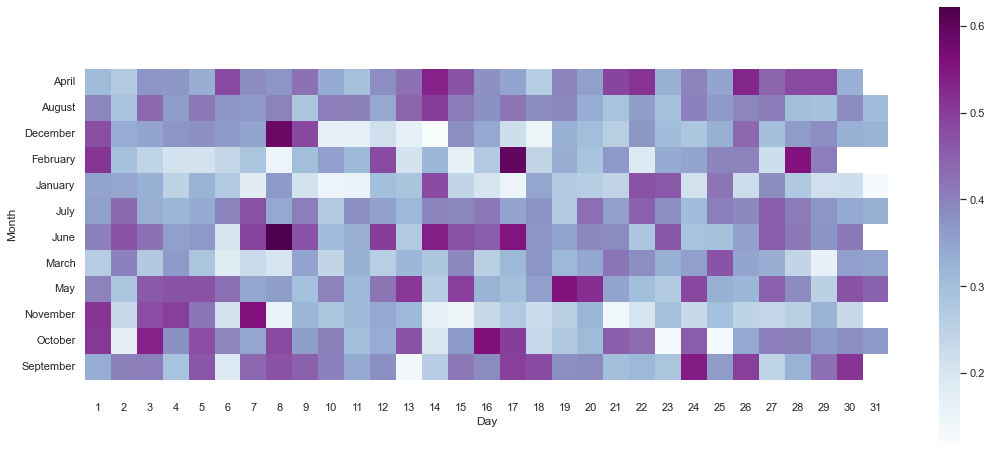

In [56]:

plt.figure(figsize=(18, 8))

# heatmap dla średniej PM2.5 dla godzin i miesięcy
df_train = data_df.groupby(["arrival_date_month", "arrival_date_day_of_month"])["is_canceled"].mean().reset_index()
df_train = df_train.pivot("arrival_date_month", "arrival_date_day_of_month", "is_canceled")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("Day")
plt.ylabel("Month");

In [57]:

features = data_df.drop(columns=["is_canceled","total_guests"], axis=1).columns
# features

In [58]:

x = data_df[features]
y = data_df["is_canceled"]

In [59]:

my_label_encoder = LabelEncoder()

for el in x:
    if x[el].dtype == object:
        my_label_encoder.fit(x[el]) 
        tmp = my_label_encoder.transform(x[el]).reshape((-1,1))
        x[el] = pd.DataFrame(tmp)

x = x.ffill(0)

### Wybór najlepszego modelu

In [60]:

models = [("Dummy_Model",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42, solver="liblinear")),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())]

split = KFold(n_splits=4, shuffle=True, random_state=42)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

In [72]:

# Preprocessing, fitting, making predictions and scoring for every model:
accuracy = []
fbeta = []
tm = []
model_name = []
for name, model in models:
    start = time()
    cv_results = cross_val_score(model, x, y, cv=split, scoring="accuracy")
    fbeta_res = cross_val_score(model, x, y, cv=split, scoring=fbeta_scorer)
    mean_score = round(np.mean(cv_results), 4)
    fbeta_score = round(np.mean(fbeta_res), 4)
    end = time()
    cross_val_time = round(end-start,4)
    accuracy.append(mean_score)
    fbeta.append(fbeta_score)
    tm.append(cross_val_time)
    model_name.append(name)
    print(f"{name}  f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")

Dummy_Model  f-beta: 0.3702, accuracy score: 0.5344, time: 0.1844
DecisionTree_Model  f-beta: 0.7658, accuracy score: 0.828, time: 4.5997
RandomForest_Model  f-beta: 0.8659, accuracy score: 0.8805, time: 78.6487
LogisticRegression_Model  f-beta: 0.7257, accuracy score: 0.7802, time: 11.9077
XGBBoost_Model  f-beta: 0.8412, accuracy score: 0.8689, time: 27.4853
Gaussian_Model  f-beta: 0.4918, accuracy score: 0.5333, time: 0.6197
KNN_Model  f-beta: 0.6823, accuracy score: 0.7619, time: 26.6853


|**Nazwa modelu**           |**Accuracy score** |**F-beta score**| **Time**    |
| ------------------------- |:-----------------:| --------------:|-------------|
| Dummy_model               |       0.5344      |    0.3702      |   0.1844    |
| DecisionTree_model        |       0.8280      |    0.7658      |   4.5997    |
| **RandomForest_model**    |     **0.8805**    | **0.8659**     |**78.6487**  | 
| LogisticRegression_model  |       0.7802      |    0.7257      |  11.9077    |
| XGBoost_model             |       0.8689      |    0.8412      |  27.4853    | 
| Gaussian_model            |       0.5333      |    0.4918      |   0.6197    |
| KNN_model                 |       0.7619      |    0.6823      |  26.6853    |

* ##### Przetestowaliśmy siedem różnych modeli. Po otrzymaniu wyników accuracy i F-bety zastanawialiśmy się nad modelami: Random Forest oraz XGBoost. 
* ##### Model XGBoost uzyskał niewiele niższe wyniki accuracy i F-bety, za to czasowo okazał się korzystniejszy. 
* ##### Mimo tego, że model Random Forest jest najbardziej "czasochłonny", uznaliśmy, że jest najbardziej miarodajny i idealny dla naszego biznesu.

In [62]:

comparison = {"Models name": model_name,
                "Accuracy score":accuracy,
                "F-beta score": fbeta,
                "Time": tm}

In [63]:

pd.DataFrame(comparison)

,Models name,Accuracy score,F-beta score,Time
0,Dummy_Model,0.53390,0.37420,0.21970
1,DecisionTree_Model,0.82800,0.76580,4.57420
2,RandomForest_Model,0.88050,0.86590,170.41660
3,LogisticRegression_Model,0.78020,0.72570,11.12970
4,XGBBoost_Model,0.86890,0.84120,25.80040
5,Gaussian_Model,0.53330,0.49180,0.60670
6,KNN_Model,0.76190,0.68230,24.49100


### Wizualizacja wyników

* Krzywa ROC

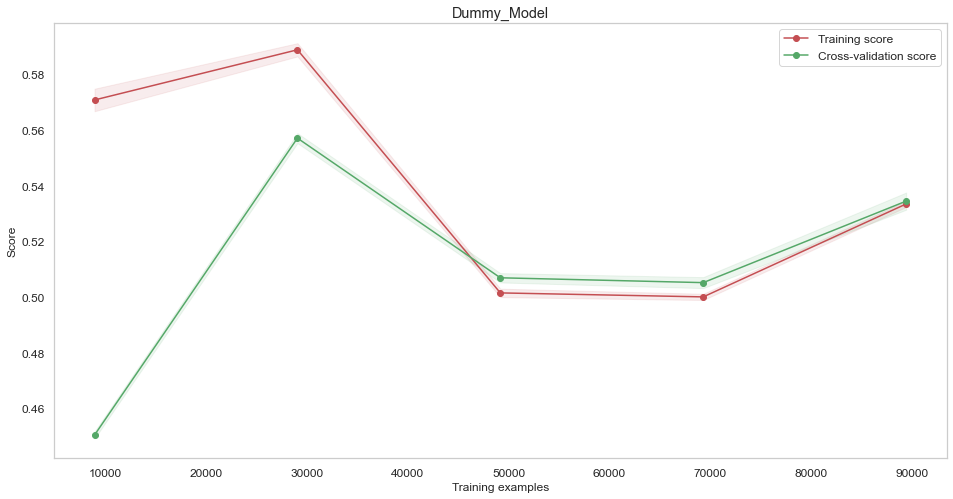

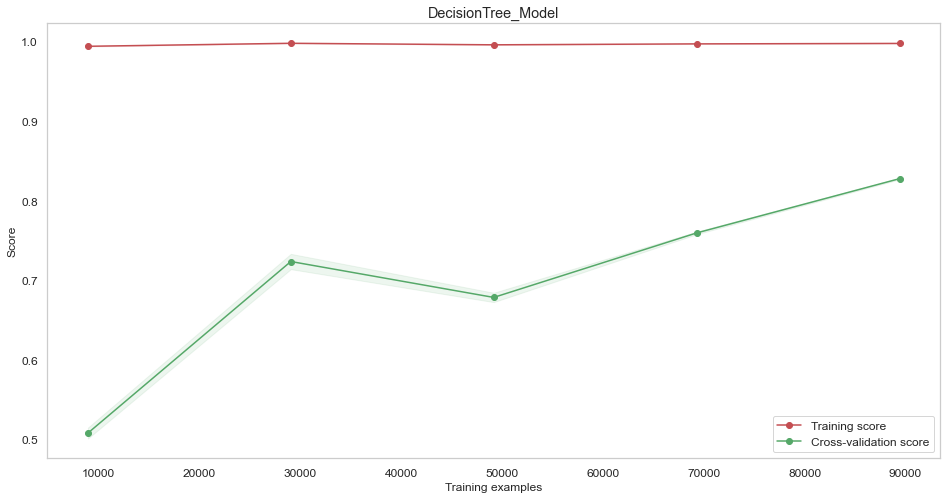

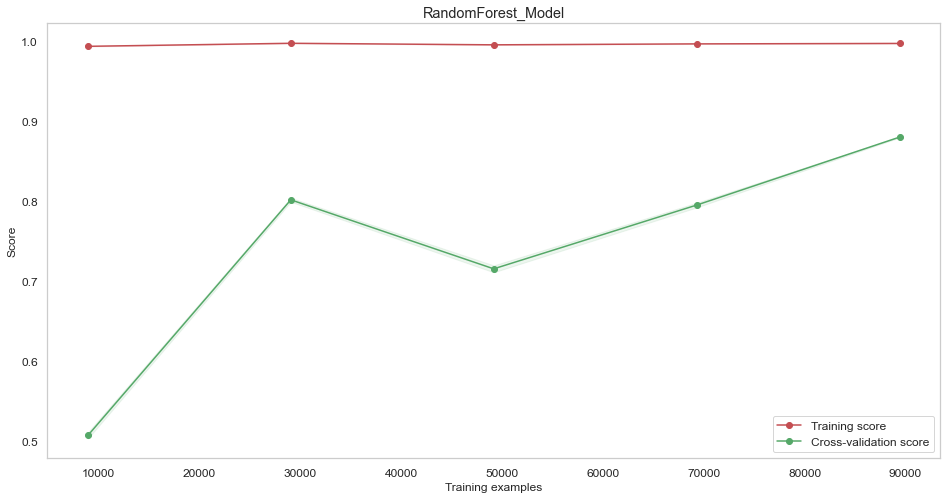

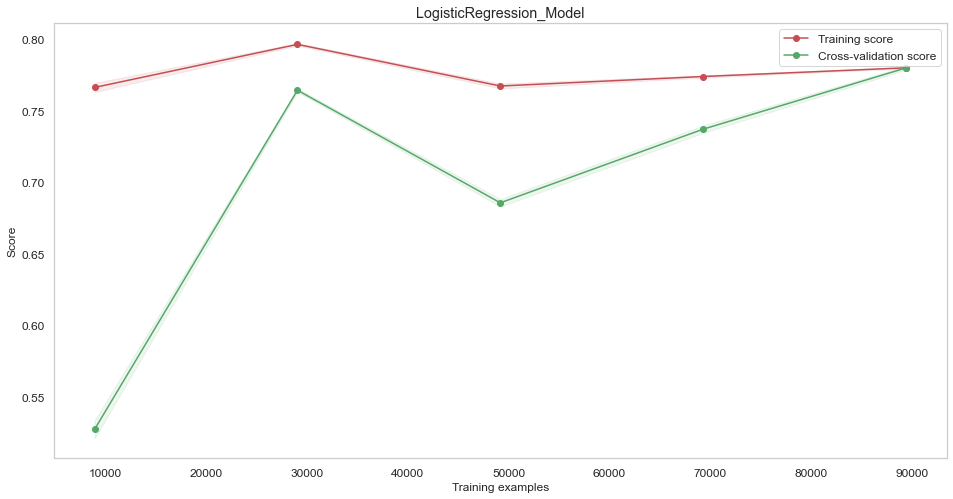

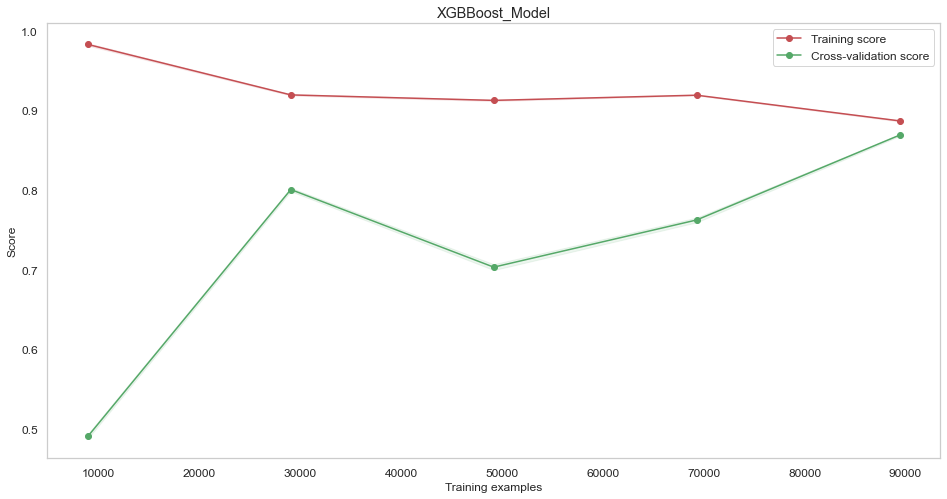

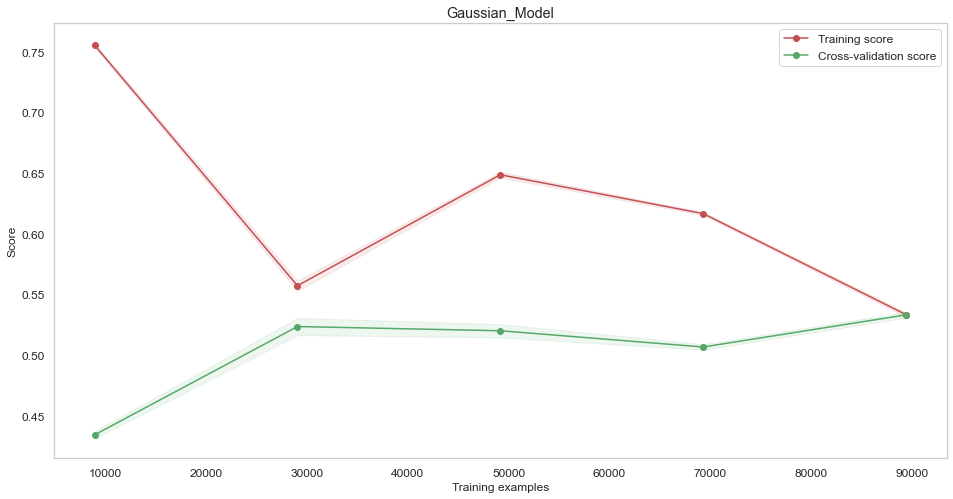

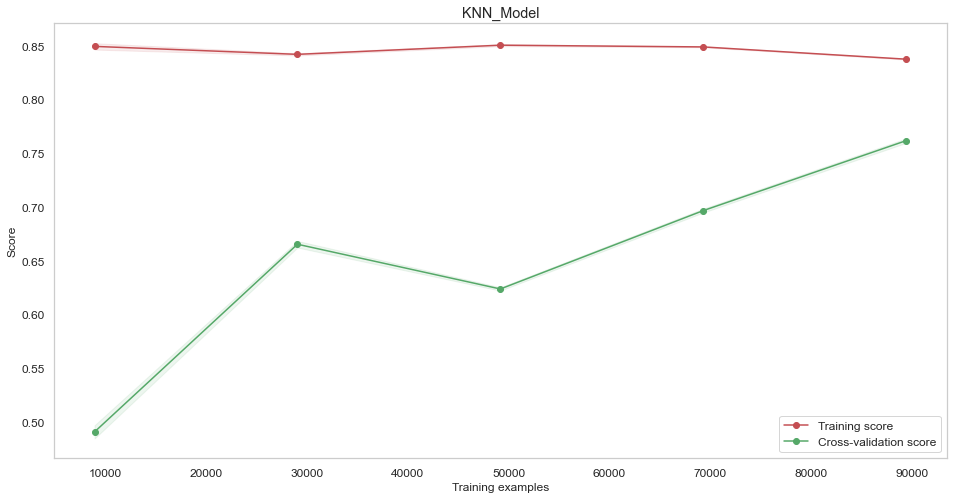

In [64]:

for name, model in models:
    skplt.estimators.plot_learning_curve(model, x, y,name, cv=split)
    plt.show()

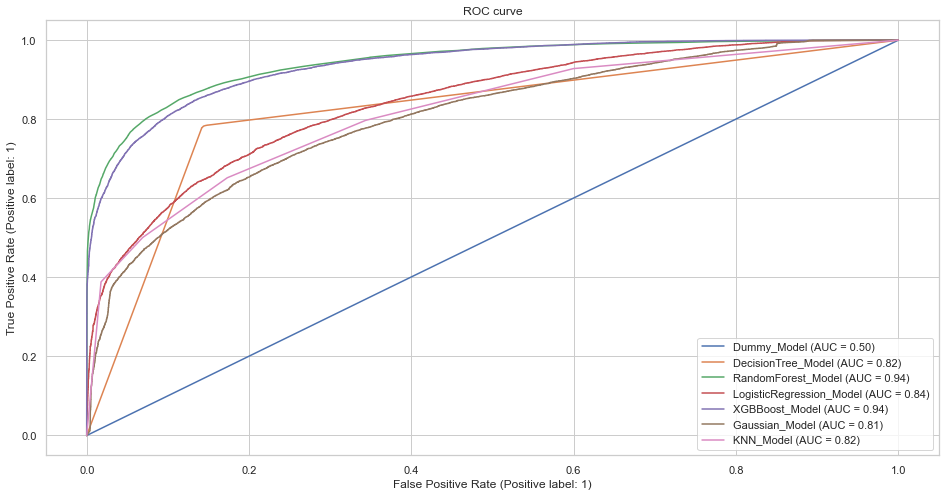

In [75]:

warnings.filterwarnings("ignore")

x1 = np.array(x)
y1= np.array(y)

fig, ax = plt.subplots()

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            plot_roc_curve(model, x1_test, y1_test, ax=ax, name=name)
_ = ax.set_title("ROC curve")

* Powyższy wykres ilustruje krzywe ROC (oraz wyniki AUC) dla każdego testowanego modelu. 
* Krzywe te idealnie pokazują znikome różnice między modelami Random Forest i XGBoost, na korzyść modelu, który wybraliśmy.
* Różnica w miarze AUC między tymi wynikami jest tak mała, że zaokrąglenie do liczb setnych, nie uwzględnia nawet tych różnic.




* ### Macierz pomyłek

* ##### Macierz pomyłek dobrze porównuje liczbę błędnie i poprawnie oszacowanych i prawdziwych wartości.
* ##### Porównajmy jak wyglądają macierze dla naszych dwóch modeli: Random Forest i XGBoosta.

In [66]:

x1 = np.array(x)
y1= np.array(y)

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            y1_pred = model.predict(x1_test)
            print(f"{name}\n",confusion_matrix(y1_test, y1_pred))

Dummy_Model
 [[11982  6886]
 [ 6802  4132]]
DecisionTree_Model
 [[16171  2697]
 [ 2402  8532]]
RandomForest_Model
 [[17853  1015]
 [ 2542  8392]]
LogisticRegression_Model
 [[17019  1849]
 [ 4672  6262]]
XGBBoost_Model
 [[17398  1470]
 [ 2493  8441]]
Gaussian_Model
 [[ 5583 13285]
 [  617 10317]]
KNN_Model
 [[15600  3268]
 [ 3806  7128]]


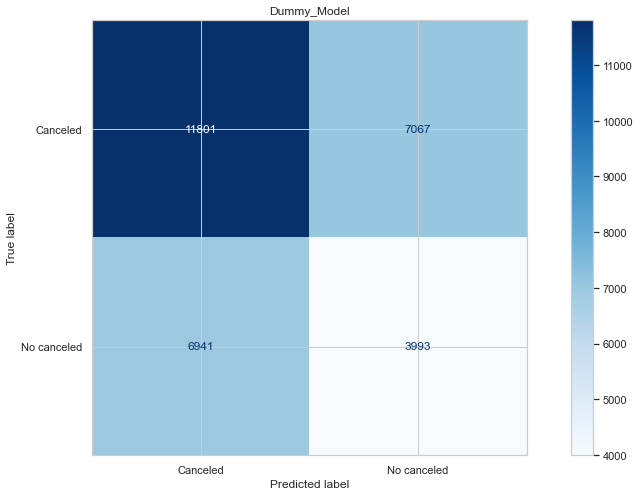

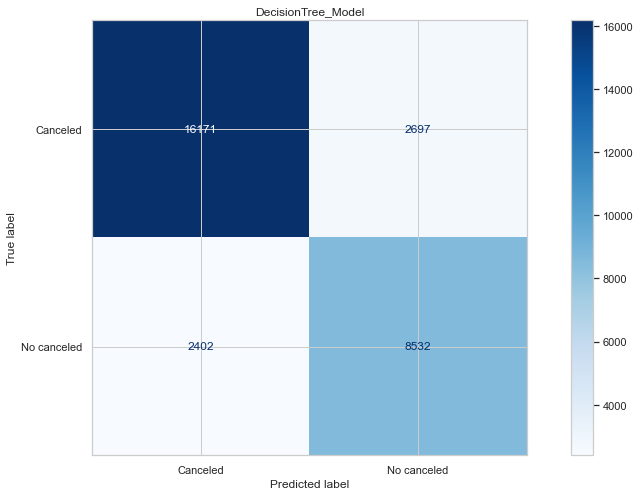

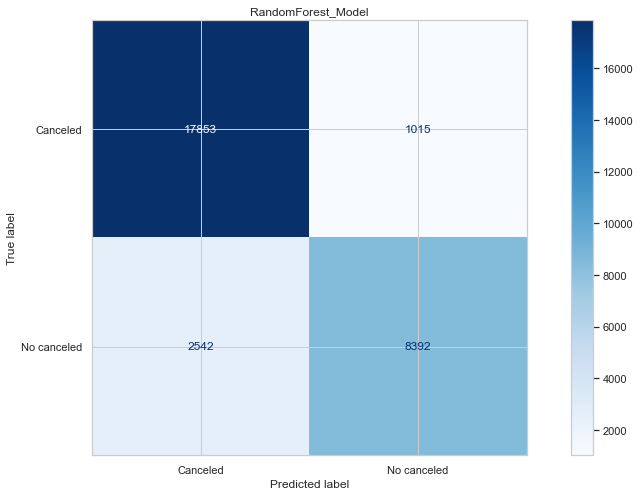

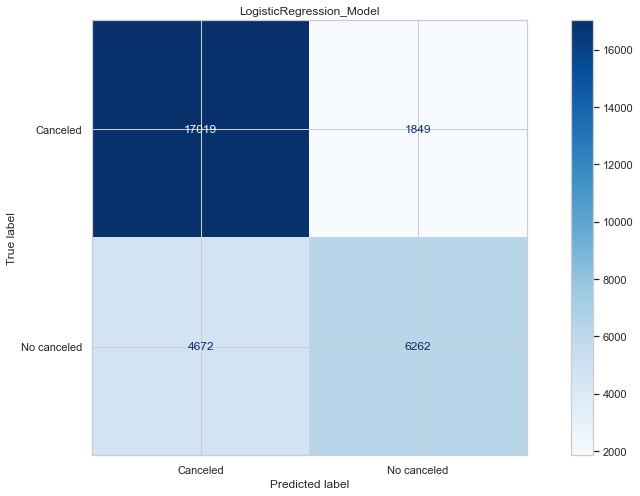

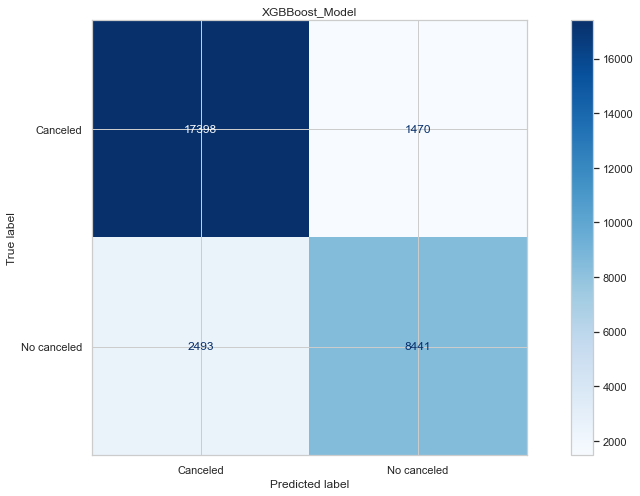

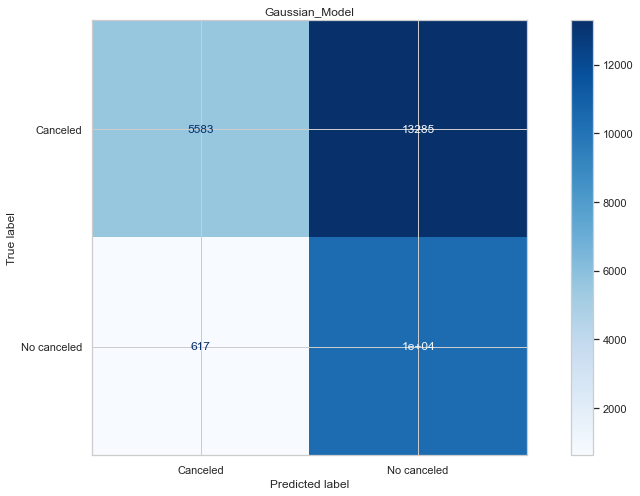

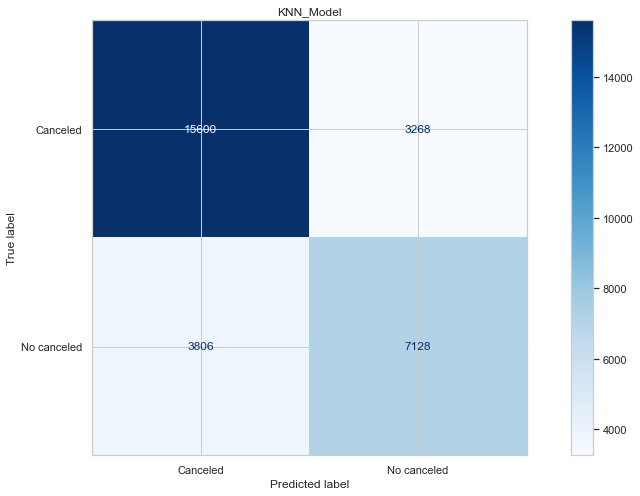

In [83]:

for name, model in models:
    plot_confusion_matrix(model, x1_test, y1_test,display_labels=['Canceled','No canceled'],cmap=plt.cm.Blues)
    plt.title(f"{name}")
    plt.show()

### Najważniejsze zmienne dla modelu Random Forest 

* ##### Użyliśmy funkcji feature_importances_, która określiła nam "ważność" poszczególnych zmiennych. 

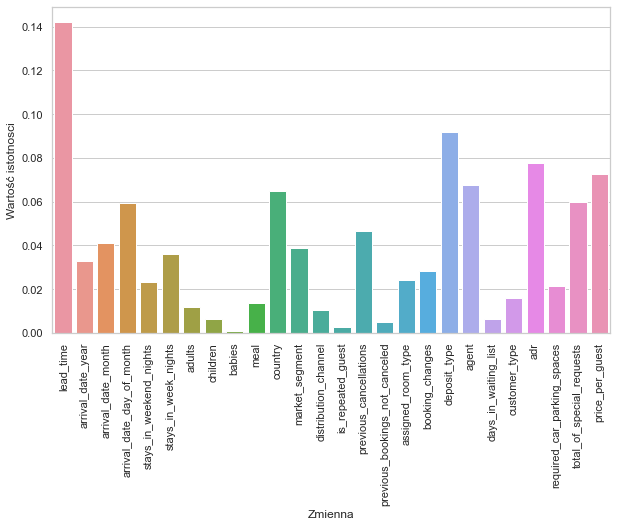

In [68]:

model = RandomForestClassifier(n_estimators=100)
model.fit(x, y)
rf = pd.DataFrame({"Zmienna" : x.columns,
              "Wartość istotnosci": model.feature_importances_})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid")
ax = sns.barplot(x="Zmienna", y="Wartość istotnosci", data=rf)
for label in ax.get_xticklabels():
    label.set_rotation(90)

In [69]:

rf.sort_values(by='Wartość istotnosci', ascending=False)[:17]

,Zmienna,Wartość istotnosci
0,lead_time,0.14210
18,deposit_type,0.09177
22,adr,0.07769
25,price_per_guest,0.07249
19,agent,0.06762
10,country,0.06496
24,total_of_special_requests,0.05962
3,arrival_date_day_of_month,0.05955
14,previous_cancellations,0.04633
2,arrival_date_month,0.04085


* ##### Z otrzymanych informacji wybraliśmy zmienne o wartości istotności powyżej 0.2.
* ##### Zmienne te wykorzystaliśmy do optymalizacji wybranego przez nas modelu.

### Optymalizacja modelu **Random Forest**

In [70]:

X = data_df[['lead_time','deposit_type','adr','price_per_guest','agent','country','arrival_date_day_of_month','total_of_special_requests','previous_cancellations','arrival_date_month','market_segment','stays_in_week_nights','arrival_date_year','booking_changes','assigned_room_type','stays_in_weekend_nights','required_car_parking_spaces']]
y=data_df['is_canceled']
Ran_forest_enh = RandomForestClassifier(max_depth=None, min_samples_leaf=2, n_jobs=1, random_state=100, max_features='sqrt', n_estimators=200)

accuracy = []
fbeta = []
tm = []
model_name = []

start = time()
cv_results = cross_val_score(model, x, y, cv=split, scoring="accuracy")
fbeta_res = cross_val_score(model, x, y, cv=split, scoring=fbeta_scorer)
mean_score = round(np.mean(cv_results), 4)
fbeta_score = round(np.mean(fbeta_res), 4)
end = time()
cross_val_time = round(end-start,4)
accuracy.append(mean_score)
fbeta.append(fbeta_score)
tm.append(cross_val_time)
model_name.append(name)
print(f"Random Forest model: f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")

Random Forest model: f-beta: 0.8643, accuracy score: 0.88, time: 233.1123


|**Nazwa modelu**           |**Accuracy score** |**F-beta score**| **Time**    |
| ------------------------- |:-----------------:| --------------:|-------------|
| RandomForest_model        |       0.8800      |    0.8643      |   233.1123  |

* ##### Porównanie

**Przed optymalizacją**

|**Nazwa modelu**           |**Accuracy score** |**F-beta score**| **Time**    |
| ------------------------- |:-----------------:| --------------:|-------------|
| RandomForest_model        |     0.8805        |   0.8659       | 78.6487     | 

**Po optymalizacji**

|**Nazwa modelu**           |**Accuracy score** |**F-beta score**| **Time**    |
| ------------------------- |:-----------------:| --------------:|-------------|
| RandomForest_model        |       0.8800      |    0.8643      |   233.1123  |

Użyte przez nas parametry:
* max_depth=None, 
* min_samples_leaf=2, 
* n_jobs=1, 
* random_state=100, 
* max_features='sqrt', 
* n_estimators=200

oraz zmienne, które zostały uznane za najbardziej istotne, nie poprawiły w ogóle wyników naszego modelu a okazały się jeszcze bardziej czasochłonne.

* Optymalizacja okazała się zbędna.

### Jakie korzyści może przynieść dla biznesu użycie naszego modelu?